# Определение возраста покупателей

# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

# План работы над проектом

1. Провести исследовательский анализ набора фотографий.
2. Подготовить данные к обучению.
3. Обучить нейронную сеть и рассчитайте её качество.

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')

## Исследовательский анализ данных

In [2]:
try:
    df = pd.read_csv('/datasets/faces/labels.csv')
except:
    df = pd.read_csv('/faces/labels.csv')

In [3]:
df.shape

(7591, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Датасет содержит 2 столбца:

- file_name содержит имя файла;
- real_age целевой признак, в формате int.

In [5]:
df.sample(5)

,file_name,real_age
3970,003970.jpg,25
4822,004822.jpg,43
2603,002603.jpg,36
2888,002888.jpg,49
1844,001844.jpg,50


In [6]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


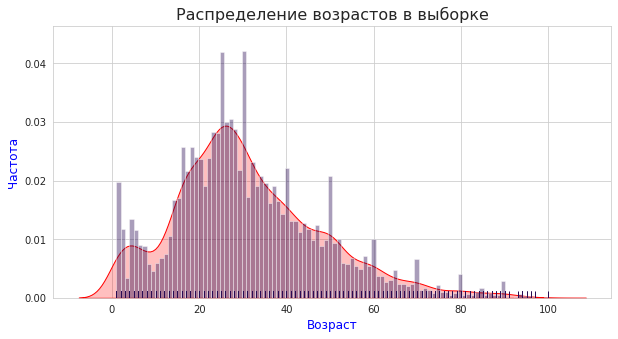

In [7]:
plt.figure(figsize=(10, 5))
sns.set_style('whitegrid')
sns.set_palette('inferno')
sns.distplot(df['real_age'],
             bins=100,
             rug=True, 
             kde_kws={'shade':True, 'color':'r'})
plt.xlabel('Возраст', fontsize=12, color='b')
plt.ylabel('Частота', fontsize=12, color='b')
plt.title('Распределение возрастов в выборке', fontsize=16)
plt.show()

Выборка содержит все возрастные категории (от 1 до 100). Распределение скошено вправо. Большинство изображений это объекты в возрасте 20-35 лет. Имеются пики в "юбилейные" годы (25, 30, 40 и т.д.). Скорее всего это связанно с тем, что точный возраст человека на изображении неизвестен, поэтому указывают примерный.

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=42)

Found 7591 validated image filenames.


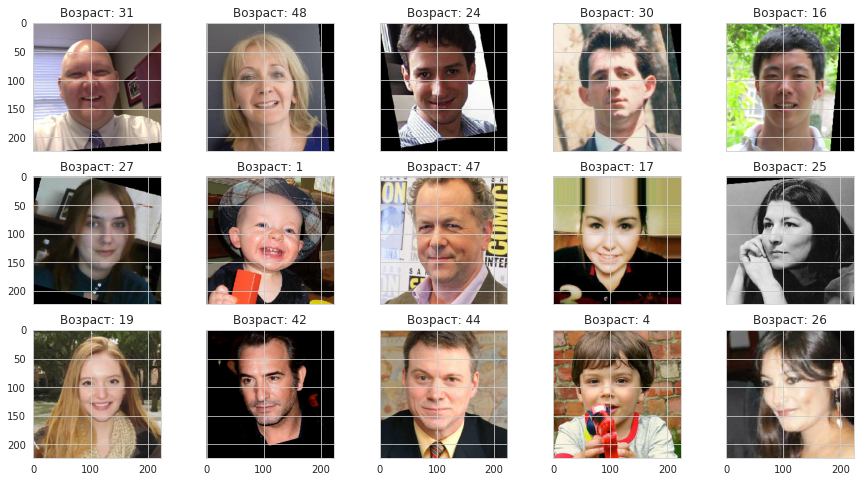

In [9]:
fig, ax = plt.subplots(nrows = 3, ncols=5,figsize=(15, 8), sharey=True, sharex=True)

for ax_x in ax.flatten():
    random_batch = int(np.random.uniform(0, len(train_gen_flow)))
    batch = train_gen_flow[random_batch] 
    image, label = batch 
    
    character = image[0]
    age = label[0]
    
    ax_x.imshow(character)
    ax_x.set_title(f'Возраст: {age}') 
plt.show()

**Вывод**:

В результате предварительного анализа данных установили:
- предоставлено 7591 цветное изображение с разметкой по возрасту;
- пропуски отсутствуют;
- присутствуют значения от 1 года до 100 лет;
- средний возраст равен 31 году;
- в данных имеется большое количество детских фотографий по сравнению с фотографиями взрослых, гистограмма показала распределение со скосом вправо;
- изображения в целом согласуются с разметкой возраста: присутствуют и младенцы, и пожилые люди;
- изображения не имеют определенного стиля: имются фотографии в профиль и анфас, цветные и черно-белые, с высоким и низким разрешением, разные условия освещенности, наличие посторонних предметов частично закрывающих лица, часть изображений повернута на случайный угол.

Можно отметить, что модель хорошо обучится на картинках с возрастом от 20 до 35. Они приедставлены в большом объеме. По другим возрастам количество фоторгафий уменьшается. На них модель может чаще ошибаться.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels_age_data = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True,  validation_split=0.25)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels_age_data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        subset='training',
        class_mode='raw',
        seed=15243
    )
    return train_gen_flow


def load_test(path):
    labels_age_data = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels_age_data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        subset='validation',
        class_mode='raw',
        seed=15243
    )
    return test_gen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer, metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model


```

```

<class 'tensorflow.python.keras.engine.sequential.Sequential'>


Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 89s - loss: 217.4835 - mae: 10.6451 - val_loss: 622.0578 - val_mae: 19.5862
Epoch 2/10
356/356 - 69s - loss: 86.8128 - mae: 7.0717 - val_loss: 147.4684 - val_mae: 9.1535
Epoch 3/10
356/356 - 67s - loss: 61.0676 - mae: 5.9601 - val_loss: 75.1773 - val_mae: 6.5762
Epoch 4/10
356/356 - 70s - loss: 45.7575 - mae: 5.1931 - val_loss: 82.9959 - val_mae: 6.7687
Epoch 5/10
356/356 - 70s - loss: 34.8767 - mae: 4.5310 - val_loss: 76.5643 - val_mae: 6.5956
Epoch 6/10
356/356 - 70s - loss: 24.9443 - mae: 3.8432 - val_loss: 111.4620 - val_mae: 7.9959
Epoch 7/10
356/356 - 42s - loss: 20.7728 - mae: 3.4720 - val_loss: 74.8894 - val_mae: 6.3527
Epoch 8/10
356/356 - 47s - loss: 16.0398 - mae: 3.0692 - val_loss: 62.1159 - val_mae: 5.9087
Epoch 9/10
356/356 - 42s - loss: 13.8481 - mae: 2.8268 - val_loss: 68.6577 - val_mae: 6.2190
Epoch 10/10
356/356 - 42s - loss: 13.2425 - mae: 2.7578 - val_loss: 63.0421 - val_mae: 5.8471
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 63.0421 - mae: 5.8471
Test MAE: 5.8471




```

**Вывод:**

Модель сверточной нейронной сети построена на ResNet50. За 10 эпох результат MAE на тестовой выборке составил 5.8, что соответствует условиям задачи.

## Анализ обученной модели

Для анализа возраста людей по фотографии была использована архитектура `ResNet50`. Было задано 10 эпох и функция оптимизации для нахождения минимума `Adam` с шагом `lr=0.0001`. По итогам анализа мы получили значение метрики `mean absolute error` для обучающей и для валидационной выборки. Значение `MAE` для обучающей **2.7578**, а для валидационной - **5.8471**.

Целью проекта было построить модель, которая определит приблизительный возраст человека в прикассовой зоне магазина для:
- анализа покупок и предложения товаров, которые могут заинтересовать покупателей этой возрастной группы;
- контроля добросовестности кассиров при продаже алкоголя.


Обученная модель может определить возраст клиета с точностью до 6 лет. Погрешность в 6 лет для определения группы покупателей является неплохим результатом, т.к. категории покупателей по возрасту разделяют в диапазоне 8-12 лет. Что касается контроля добросовестности кассиров при продаже алкоголя, то такая погрешность едва ли приемлема. Однако есть возможность, что при попадании клиентов в нижние 1-2 группы, система будет запрашивать их удостоверения личности, чтобы подтвердить возраст.